# Toronto Neighborhoods Assignment

### Importing librarys

In [42]:
#!pip install beautifulsoup4
#!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## Question 1

### Webscraping wikipedia postal codes from Canada

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source,'xml')

### Transforming to DataFrame and cleaning data

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [4]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Question 1 answer:

In [6]:
# Shape of data frame
df.shape

(103, 3)

## Question 2

In [12]:
coordinates = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')

coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
coord_merged = pd.merge(coordinates, df, left_on='Postal Code', right_on='PostalCode')

In [21]:
df2 = coord_merged[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]

### Question 2 answer:

In [22]:
df2

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


## Question 3

### First, let´s plot all neighborhoods from Toront to visualize how they are distributed through the city

In [24]:
toronto = df2[df2['Borough'].str.contains("Toronto")]
toronto = toronto.drop(['PostalCode'], axis = 1)

In [32]:
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=12)

for lat,lng,borough,neighborhood in zip(toronto['Latitude'],toronto['Longitude'],toronto['Borough'],toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#ffffff',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

In [45]:
X = df2.drop(['PostalCode','Borough','Neighborhood'],1)

In [38]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

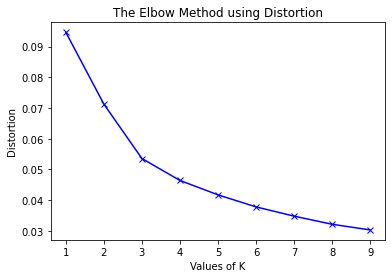

In [43]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### Using the Elbow Method to determine best K from our K-means, we can see 3 is the best choice here, so let´s split the neighborhoods in 3 and visualize how they show on map

In [47]:
k=3

kmeans = KMeans(n_clusters = k,random_state=0).fit(X)
kmeans.labels_
df2.insert(0, 'Cluster Labels', kmeans.labels_)

In [53]:
df2['Cluster Labels'].value_counts()

0    51
1    29
2    23
Name: Cluster Labels, dtype: int64

In [56]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood'], df2['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters